   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.2 MB/s eta 0:00:00


100%|██████████| 170M/170M [00:02<00:00, 76.5MB/s]


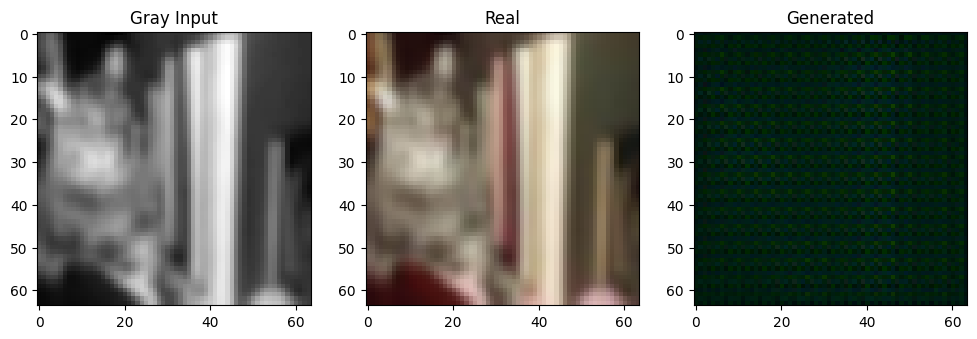

In [1]:
!pip install torchvision --quiet

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(4, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 1),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        inp = torch.cat([x, y], dim=1)
        return self.main(inp)

G = Generator()
D = Discriminator()

loss_fn = nn.BCELoss()
optimizer_G = torch.optim.Adam(G.parameters(), lr=0.0002)
optimizer_D = torch.optim.Adam(D.parameters(), lr=0.0002)

for real_imgs, _ in dataloader:
    gray = real_imgs.mean(dim=1, keepdim=True)
    fake_imgs = G(gray)
    real_labels = torch.ones(real_imgs.size(0), 1)
    fake_labels = torch.zeros(real_imgs.size(0), 1)
    outputs = D(gray, real_imgs)
    d_loss_real = loss_fn(outputs, real_labels)
    outputs = D(gray, fake_imgs.detach())
    d_loss_fake = loss_fn(outputs, fake_labels)
    d_loss = d_loss_real + d_loss_fake
    optimizer_D.zero_grad()
    d_loss.backward()
    optimizer_D.step()
    outputs = D(gray, fake_imgs)
    g_loss = loss_fn(outputs, real_labels)
    optimizer_G.zero_grad()
    g_loss.backward()
    optimizer_G.step()
    break

with torch.no_grad():
    fake = G(gray)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(gray[0].squeeze(), cmap='gray')
    plt.title("Gray Input")
    plt.subplot(1, 3, 2)
    plt.imshow(real_imgs[0].permute(1, 2, 0))
    plt.title("Real")
    plt.subplot(1, 3, 3)
    plt.imshow(fake[0].permute(1, 2, 0).clamp(0, 1))
    plt.title("Generated")
    plt.show()
